
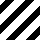
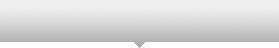
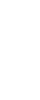
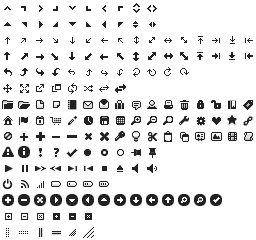
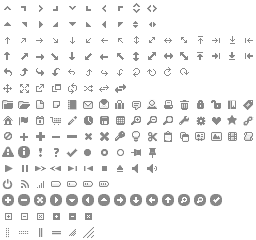
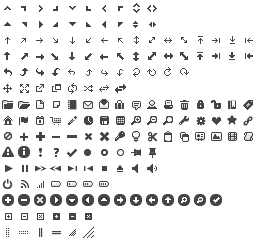
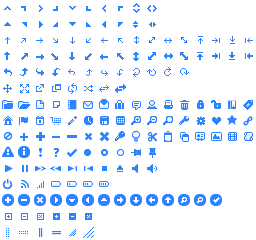
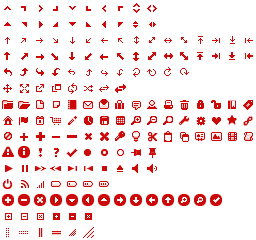
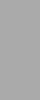
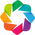
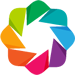
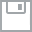
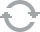
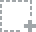
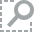
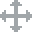
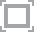
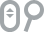

In [1]:
from pandas import DataFrame
from bokeh.plotting import show, output_notebook
output_notebook()

## Build a map

In [2]:
FONT = "Arial"
FONT_SIZE = "20pt"
WATER_COLOR_RANGE = ["#8c9494", "#8398a2", "#7c9baa", "#73a1b4", "#6aa6bd", "#62abc7", "#5aafd0", "#52b4d9", "#49bae4", "#3fc0f0"]
SANITATION_COLOR_RANGE = ["#d45500", "#da670f", "#eb7e1f", "#eb941f", "#ebb01f", "#f2c83d", "#d3cc4f", "#86c26f", "#4db181", "#15b598"]
NODATA_COLOR = "#eeeeee"
BLUE = WATER_COLOR_RANGE[5]
GREEN = "#43C4AD"
GRAY = "#CCCCCC"
DARK_GRAY = "#6B6B73"
ORANGE = "#FFA500"
ORANGE_SHADOW = "#D48702"
AXIS_FORMATS = dict(
    minor_tick_in=None,
    minor_tick_out=None,
    major_tick_in=None,
    major_label_text_font=FONT,
    major_label_text_font_size="10pt",
    major_label_text_font_style="bold",
    axis_label_text_font=FONT,
    axis_label_text_font_size="10pt",
    
    axis_line_color=GRAY,
    major_tick_line_color=GRAY,
    major_label_text_color=DARK_GRAY,
    
    major_tick_line_cap="round",
    axis_line_cap="round",
    axis_line_width=3,
    major_tick_line_width=3,    
)
PLOT_FORMATS = dict(
    toolbar_location=None,
    outline_line_color="#FFFFFF",
    title_text_font=FONT,
    title_text_align='left',
    title_text_color=BLUE,
    title_text_baseline='top',
)
LINE_FORMATS = dict(
    line_width=5,
    line_cap='round',
    line_alpha=0.8,
    line_color=BLUE,
)

In [3]:
import json

# Build coordinate lists
def get_patch_coords(boundary_cell):
    boundary = json.loads(boundary_cell)
    xs = []
    ys = []
    if boundary['type'] == 'MultiPolygon':
        for polygon in boundary['coordinates']:
            for coord in polygon:
                if len(coord) == 2:
                    xs.append(coord[0])
                    ys.append(coord[1])  
                else:
                    for co in coord:
                        xs.append(co[0])
                        ys.append(co[1])  
    elif boundary['type'] == 'Polygon':
        polygon = boundary['coordinates'][0]
        for coord in polygon:
            xs.append(coord[0])
            ys.append(coord[1])
    return xs, ys

def get_patches_coords(boundary_cell):
    boundary = json.loads(boundary_cell)
    xs = []
    ys = []
    if boundary['type'] == 'MultiPolygon':
        for polygon in boundary['coordinates']:
            for coord in polygon:
                if len(coord) == 2:
                    xs.append(coord[0])
                    ys.append(coord[1])  
                else:
                    for co in coord:
                        xs.append(co[0])
                        ys.append(co[1])  
                    xs.append('Nan')
                    ys.append('Nan')
    elif boundary['type'] == 'Polygon':
        polygon = boundary['coordinates'][0]
        for coord in polygon:
            xs.append(coord[0])
            ys.append(coord[1])
    return xs, ys

def build_patches_coords_lists(boundary_series):
    xs, ys = zip(*boundary_series.map(get_patches_coords))
    return xs, ys


def build_patch_coords_lists(boundary_series):
    xs, ys = zip(*boundary_series.map(get_patch_coords))
    return xs, ys

In [4]:
# GET THE DATA
from numpy import where
from bokeh.palettes import brewer
from pandas import DataFrame, merge

from country.models import Country
from stats.models import StatValue

def get_active_data(data, active_year, palette=WATER_COLOR_RANGE):
    def _get_color(value):
        if value < 0: return GRAY
        index = int(value / 10) - 1
        return palette[index]

    data['active_year'] = active_year
    data['active_year_value'] = data[active_year]
    data['color_for_active_year'] = data[active_year].apply(_get_color)
    data['active_year_value'] = where(data['active_year_value'] < 0, 'No Data', data['active_year_value'])
    return data

def get_data_with_countries(year_of_color=1990, stat_code='WNTI_%', palette=WATER_COLOR_RANGE):
    # Get the countries data frame
    countries = Country.objects.exclude(boundary='')
    #countries = countries.filter(region__in=[1, 2, 3, 6, 7])  # Only African countries
    countries = countries.values('name', 'boundary', 'id')
    countries_df = DataFrame.from_records(countries)
    countries_df['patches_xs'], countries_df['patches_ys'] = build_patches_coords_lists(countries_df['boundary'])  
    countries_df['patch_xs'], countries_df['patch_ys'] = build_patch_coords_lists(countries_df['boundary'])  

    
    # Get the stats for access to water
    stats = StatValue.objects.filter(description__code=stat_code)
    stats = stats.values('value', 'year', 'country_id')
    stats_df = DataFrame.from_records(stats, coerce_float=True)
    
    # Pivot it before merging
    pivot_df = stats_df.pivot(columns='year', index='country_id', values='value')  
    pivot_df['id'] = pivot_df.index
    
    # Merge the countries and stats together
    merged_df = merge(countries_df, pivot_df, how='left')
    merged_df = merged_df.fillna(value=-99)
    
    # Color it
    colored_df = get_active_data(merged_df, year_of_color, palette)
    return colored_df

def get_water_data_with_countries(year=1990):
    return get_data_with_countries(year, 'WNTI_%', WATER_COLOR_RANGE)

def get_sanitation_data_with_countries(year=1990):
    return get_data_with_countries(year, 'SNTI_%', SANITATION_COLOR_RANGE)

data = get_water_data_with_countries()
data.head()

,boundary,id,name,patches_xs,patches_ys,patch_xs,patch_ys,1990,1991,1992,...,2006,2007,2008,2009,2010,2011,2012,active_year,active_year_value,color_for_active_year
0,"{""type"": ""Polygon"", ""coordinates"": [[[61.21081...",112,Afghanistan,"[61.2108170917, 62.230651483, 62.9846623066, 6...","[35.6500723333, 35.2706639674, 35.4040408392, ...","[61.2108170917, 62.230651483, 62.9846623066, 6...","[35.6500723333, 35.2706639674, 35.4040408392, ...",-99.0,4.8,4.9,...,43.0,46.5,50.0,53.5,57.1,60.6,64.2,1990,No Data,#CCCCCC
1,"{""type"": ""Polygon"", ""coordinates"": [[[20.59024...",166,Albania,"[20.5902474301, 20.4631750831, 20.605181919, 2...","[41.8554041611, 41.5150890163, 41.0862263047, ...","[20.5902474301, 20.4631750831, 20.605181919, 2...","[41.8554041611, 41.5150890163, 41.0862263047, ...",-99.0,-99.0,-99.0,...,96.2,96.1,96.0,96.0,95.9,95.8,95.7,1990,No Data,#CCCCCC
2,"{""type"": ""Polygon"", ""coordinates"": [[[11.99950...",36,Algeria,"[11.9995056495, 8.57289310063, 5.67756595218, ...","[23.4716684026, 21.5656607122, 19.6012069768, ...","[11.9995056495, 8.57289310063, 5.67756595218, ...","[23.4716684026, 21.5656607122, 19.6012069768, ...",93.9,94.0,94.1,...,85.2,84.4,83.7,83.7,83.8,83.9,83.9,1990,93.9,#49bae4
3,"{""type"": ""MultiPolygon"", ""coordinates"": [[[[16...",18,Angola,"[16.3265283546, 16.5731799659, 16.8601908708, ...","[-5.87747039147, -6.62264454512, -7.2222978654...","[16.3265283546, 16.5731799659, 16.8601908708, ...","[-5.87747039147, -6.62264454512, -7.2222978654...",42.4,42.4,42.4,...,49.5,50.2,51.0,51.8,52.6,53.4,54.3,1990,42.4,#73a1b4
4,"{""type"": ""MultiPolygon"", ""coordinates"": [[[[-6...",87,Argentina,"[-65.5, -66.45, -66.95992, -67.56244, -68.6333...","[-55.2, -55.25, -54.89681, -54.87001, -54.8695...","[-65.5, -66.45, -66.95992, -67.56244, -68.6333...","[-55.2, -55.25, -54.89681, -54.87001, -54.8695...",93.8,94.1,94.4,...,97.7,97.9,98.1,98.2,98.4,98.6,98.7,1990,93.8,#49bae4


In [5]:
from bokeh.models import LinearAxis, SingleIntervalTicker

def construct_line(data, palette):
    year_range = range(1990, 2013)

    data = get_sanitation_data_with_countries()
    data = data[data.name == 'South Africa']
    data = data[year_range].transpose()
    data['country'] = data.iloc[:,0]
    source = ColumnDataSource(data)

    xdr = Range1d(1990, 2013)
    ydr = Range1d(0, 100)
    line_plot = Plot(
        x_range=xdr,
        y_range=ydr,
        title="",
        plot_width=250,
        plot_height=250,
        min_border_right=10,
        **PLOT_FORMATS
    )
    xaxis = LinearAxis(SingleIntervalTicker(interval=50), **AXIS_FORMATS)
    yaxis = LinearAxis(SingleIntervalTicker(interval=10), **AXIS_FORMATS)   
    line_plot.add_layout(xaxis, 'left')
    line_plot.add_layout(yaxis, 'below')

    line = Line(x='index', y='country', 
                line_width = 5, line_cap="round", 
                line_color=palette[int(data['country'].mean() / 10)]
                )
    line_plot.add_glyph(source, line)

    return line_plot

# Linked brushing

In [6]:
from bokeh.models import Circle, TapTool
from bokeh.models import (
    ColumnDataSource,
    Range1d,
    Plot,
    Patches,
    Patch,
    HoverTool,
)
from bokeh.plotting import gridplot


def get_lin_params():
    year_range = range(1990, 2013)
    xdr = Range1d(year_range[0], year_range[-1])
    ydr = Range1d(0, 100)
    return year_range, xdr, ydr


def get_map_params():
    # Plot and axes
    x_start, x_end = (-180, 1800)
    y_start, y_end = (-90, 90)
    xdr = Range1d(x_start, x_end)
    ydr = Range1d(y_start, y_end)
    aspect_ratio = (x_end - x_start) / (y_end - y_start)
    plot_height = 600
    plot_width = int(plot_height * aspect_ratio)
    return xdr, ydr, plot_height, plot_width

data = get_water_data_with_countries()
linked = ColumnDataSource(data)

In [30]:
year_range, xdr, ydr = get_lin_params()

line_plot = Plot(
    x_range=xdr,
    y_range=ydr,
    title="",
    plot_width=250,
    plot_height=250,
    min_border=0,
    **PLOT_FORMATS
)

for year in year_range:
    circle = Circle(x=[year], y=str(year), fill_color='color_for_active_year', line_color=None, size=5)
    circle_gr = line_plot.add_glyph(linked, circle)


xdr, ydr, plot_height, plot_width = get_map_params()
map_plot = Plot(
    x_range=xdr,
    y_range=ydr,
    title="",
    plot_width=plot_width,
    plot_height=plot_height,
    **PLOT_FORMATS
)
core_props = dict(
    
)
colored_countries = Patches(
    xs='patches_xs', ys='patches_ys',
    fill_color='color_for_active_year', fill_alpha=1, 
    line_color="#FFFFFF", line_width=1,
)

colored_countries = map_plot.add_glyph(linked, colored_countries, selection_glyph=colored_countries, nonselection_glyph=colored_countries)

xs_ys = dict(
    xs='patch_xs', ys='patch_ys'
)
blank_countries = Patches(
   fill_alpha=0, line_alpha=0, **xs_ys
)
selected_countries = Patches(
    fill_alpha=0, line_alpha=1, line_color=ORANGE, **xs_ys
)
non_selected_countries = Patches(
    fill_alpha=0, line_alpha=0, **xs_ys
)

hit_countries = map_plot.add_glyph(linked, blank_countries, selection_glyph=selected_countries, nonselection_glyph=non_selected_countries)

map_plot.add_tools(TapTool(renderers=[hit_countries]))
map_plot.add_tools(HoverTool(tooltips="@active_year<br />@name<br />@active_year_value%"))

In [31]:
show(map_plot)
show(line_plot)